# Project. Data Science Jobs Predictions

### I. Overview
---
The Australian data science job market is still continuing to grow. There is a variety of data jobs in different salary bands. Seek, one of the leading job platforms in Australia, has a wealth of information on these jobs. It is only fitting to harness this data and apply data science principles to get insights from it. For this project, we use data science to develop models to predict 1) Salary range and 2) Job Title given the job Ad Details for data science jobs. To be able to process our job Ad Details which is a chunk of text into a predictor matrix, we make sure of Natural Language Processing. 

For our Salary range prediction model, we use CountVectorizer to change our job Ad Details text into a predictor matrix. This matrix is used to train different models. Comparing the results, we were able to develop an Extra Tree model than can predict the salary range of a job given job ad details with an accuracy of 75%. If we use the % of the majority salary range in our dataset, this model has improved accuracy by 30 points. This model however cannot give us the words that are likely to occur in job details per salary range. Another model we considered which provided good results is the Logistic Rgression model. Using this, we can get the the words closely associated with each salary range. 

For Job Title prediction, we looked at the impact of the type of vectorizer we use. We compared the performance of models if we use: 1) CountVectorizer, 2) TfidfVectorizer. We compared 6 Vecrtorizer+model combinations. In general, models that used Tfidf vectorizer performed better than those that used CountVectorizer across all comparison metrics. Of the models that we used, the Tfidf+ Extra tree combo performed best outperforming our Baseline by 50 points. Tfidf+Logistic Regression is not far behind although it showed some signs of overfitting. Similar to the Salary model, we can use the Logistic Regression model if we were interested in getting the words that best identify each jobTitle.  

### II. Introduction
---
Data Science is an emerging field as the development of technology to store and process the wealth of information available has grown at exponential rates. Consequently, organizations have had to look at different ways of using data not only to gain a competitive advantage but to survive in today's market. No industry is shielded from from this trend, and this is evidenced by the growing demand for talent in manipulating and harnessing the power of data- from acquiring it to coming up with meaningful and practical insights to support business goal. 

In this project, we look to apply data science principles in analysing the Australian job market for available roles in the data science space. Specifically, we try to explore salaries and job titles for available opportunities that have to do with data.

#### II-1. Objective
---
This project has two main objectives. It aims to:

1. Understand drivers that affect the salary range for data science-related jobs and develop a model that will be able to predict the salary range of a particular data-science-related job given details of the job ad
2. Identify words in job ad details that best identify job titles and develop a model to predict job title based on job ad. 

#### II-2. Scope of Work
---
This project is limited to data science-related jobs within Australia that are advertised on seek.com.au. The study focuses only on the details of the job ad as predictive variables to create models. Other factors (i.e. economic factors, job market, etc) that could affect salary will not be considered in the models. Due to the scarcity of salary data on data science jobs in Seek, salary range will be predicted instead of point-value salary (the above objectives reflect this). Our project will also only focus on the following five data job categories: 1. Data Analyst, 2. Business Analyst, 3. Data Engineer, 4. Manager, 5. Scientist.

### III. Our Data
---

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string


%matplotlib inline

#some preprocessing and data preparation used
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from textblob import TextBlob, Word

#models used
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import SGDRegressor, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

#tools used to evaluate, compare, and contrast the different models used
from sklearn import metrics
import scipy.stats as stats
from sklearn.metrics import accuracy_score, classification_report
from math import sqrt

import logging
logging.captureWarnings(True)

#### III.1. Getting the data
---

Data is scraped from Seek.com.au. I used scrapy to implement the data retrieval. 

To address scarcity of salary data, I used salary range bins. The binning is implemented during the scraping by making use of the salary filter function on Seek. This filter is reflected on the urls of search result pages. I can these urls to segregate jobs per salary range. 

I set five start urls corresponding to my five salary range bins (0-40k, 50k-70k, 80k-120k, 150k-200k,200k+). There are a few things to note about the binning for the salary range: 1. the bins are based on the values pre-set on Seek; 2. the higher end of the range is inclusive of salaries within 10ks of that range (i.e. 75k will still fall within the 50k-70k range); 3. for jobs with salary ranges that fall in 2 bins, the lower end is considered for the binning. The removal of duplicates is mostly implemented by taking advantage of Scrapy's drop duplicate nature. Scrapy drops duplicates by recognizing the url. If it has already scraped through that url, it will not scrape again. Jobs in Seek have unique urls so even if a job appears in multiple ranges, Seek will only scrape and log it once. A graph of the scraping process is shown below.


![](scrapy_graph.png)


In [2]:
#open the scraped data into a data frame 

df = pd.read_json('seek_scraped_data.json')
print('The final  data has a shape of' , df.shape)
print('Below is an first 5 rows of our dataframe:')
df.head()

The final  data has a shape of (11967, 13)
Below is an first 5 rows of our dataframe:


,jobID,jobLink,jobTitle,jobCompany,jobLocation,jobArea,Industry,Industry_details,jobAdDetails,Worktype,Worktype2,Salary,Salary_range
0,52502036,https://www.seek.com.au/job/52502036?type=prom...,Business Analyst,Emanate Technology Pty Ltd,ACT,"[ACT, Information & Communication Technology, ...",Information & Communication Technology,Business/Systems Analysts,[Our client needs a Senior Business Analyst to...,[Contract/Temp],Contract/Temp,Contract/Temp,high
1,52368201,https://www.seek.com.au/job/52368201?type=prom...,Senior Data Engineer,Lendi,Sydney,"[Sydney, CBD, Inner West & Eastern Suburbs, In...",Information & Communication Technology,Engineering - Software,[Lendi is looking for an experienced Senior Da...,[Full Time],Full Time,Full Time,mid
2,52585993,https://www.seek.com.au/job/52585993?type=stan...,Data Entry /Office Admin,Apparel Group PTY LTD,Sydney,"[Sydney, CBD, Inner West & Eastern Suburbs, Ad...",Administration & Office Support,Administrative Assistants,"[About us, Apparel Group is a well-established...",[Part Time],Part Time,Part Time,mid_low
3,52461122,https://www.seek.com.au/job/52461122?type=prom...,Senior Microsoft Data & Analytics Consultant,BoomData Pty Ltd,Sydney,"[Sydney, North Shore & Northern Beaches, Infor...",Information & Communication Technology,Consultants,"[Make an impact while growing your skills , Va...","[$140,000 - $159,999, Full Time]",Full Time,"$140,000 - $159,999",mid_low
4,52534466,https://www.seek.com.au/job/52534466?type=stan...,Data Analyst,NTT Ltd,Melbourne,"[Melbourne, CBD & Inner Suburbs, Information &...",Information & Communication Technology,Database Development & Administration,[Is innovation part of your DNA? Do you want t...,[Full Time],Full Time,Full Time,mid_low


#### III.2. Cleaning and preparing the data
---

I scraped a total of 11,900 data points with 9 dimensions from the Seek.  The original dataset contains the following variables. 

In [3]:
print(df.columns)

Index(['jobID', 'jobLink', 'jobTitle', 'jobCompany', 'jobLocation', 'jobArea',
       'Industry', 'Industry_details', 'jobAdDetails', 'Worktype', 'Worktype2',
       'Salary', 'Salary_range'],
      dtype='object')


##### III.2.i. Removing duplicates

As mentioned above, Scrapy takes care of dropping most of the duplicates. However, jobs listed as premium jobs on seek appear both as a featured job with a unique url and a normal job with a different url. This means that these premium jobs are duplicated as Scrapy checks for duplicates through the urls. To address this issue, we remove the duplicates by checking for the jobID, unique to every job. Any duplicated jobIDs will be dropped. 

In [4]:
#drop duplicates by checking the jobID

df.drop_duplicates(subset='jobID', keep='first',inplace=True)
print('The shape of the processed df is', df.shape)

The shape of the processed df is (11769, 13)


##### III.2.ii. Removing Unnecessary Variables

We will primarily be using the jobAdDetails column as our predictor. As this column is composed of long blocks of text, we will be employing different methods to extract features from these texts. As such, we are expecting a very wide dataframe. The width of our dataframe can impact the performance of our model, hence, it is important to remove any unnecessary predictors. In the interest of taking out features that will not give us any signal, we will remove the following:
1. jobID- The jobID is unique to every job, hence, it will not be able to give us any information on either of our target variables. 
2. jobLink - Similar to jobID, this is unique to every row and as such is not going to give us any signal. 
3. jobCompany- There are a lot of companies looking to hire. Hence, jobCompany column will not bring much signal to our model
3. jobArea- there are many rows that does not contain this information. The jobLocation (city-level) will be enough to give us information on effect of location on the targets. 
4. Worktype- this column was obtained in the hopes of using it to extract information from our Salary column. However, as there is sparsity of data in our salary column, we will no longer make use of this. 
5. Salary- the original plan was to extract dollar-point salaries. The sparsity of salary data has not allowed us to do this, hence, we will drop this column and just focus on our salary range column instead. 

In [5]:
df.drop(columns=['jobArea', 'Worktype', 'jobLink','jobCompany', 'jobID', 'Salary'], inplace=True)
print('The shape of the df after dropping unnecessary columns is', df.shape)

The shape of the df after dropping unnecessary columns is (11769, 7)


Now, we have the following columns to work with. Note that our main predictors remains to be the features we will extract from the jobAdDetails column. However, we will also include the other remaining columns as additional predictors.
1. JobTitle
2. Location (City-level)
3. Industry
4. Sub-industry
5. Job Ad Details (Actual text that includes job description found on the individual job URLs)
6. Salary range. 

In [6]:
df.columns

Index(['jobTitle', 'jobLocation', 'Industry', 'Industry_details',
       'jobAdDetails', 'Worktype2', 'Salary_range'],
      dtype='object')

##### III.2.iii. Clean jobAdDetails 

Next, we proceed to cleaning our jobAdDetails column from any formatting issues. Example of an individual jobAdDetail shown below followed by the function used to clean the column.

In [7]:
#sample jobAdDetails data 
print("******---Start-sample job ad detail before cleaning---******\n",df.jobAdDetails[0],"\n******---End-sample job ad detail before cleaning---******" )

******---Start-sample job ad detail before cleaning---******
 ['Our client needs a Senior Business Analyst to support their project team.\xa0 They are\xa0undergoing a digital transformation to modernise their\xa0business systems and processes to reduce administrative burden on the Australian Medicines and Medical Devices businesses in their interactions with the organisation.\xa0They are undertaking a program to digitise, transform and modernise the\xa0business systems and infrastructure, better connecting services to get medicines and devices to patients sooner.', '\n\nTo be successful in this role you will need the following:\xa0', 'Pragmatism and the ability to collaborate with a variety of stakeholders to achieve mutual results', 'A track record of being hands on, delivering high quality services and getting things done in condensed timeframes', 'Superior communication skills along with strong organisation, stakeholder engagement and influencing skills', 'Critical thinking and abil

In [8]:
#function used to clean the jobAdDetails column of formatting issues
def clean_jobAd(x):
    #remove all trailing new line
    x= [word.strip() for word in x]
    #replace all \\xa0 and other characters resulting from formatting
    x2= str(x).replace(u'\\xa0', ' ').replace("\'", '').replace("[",'').replace("]",'')
    #remove all commas and periods that are not performing as part of speech
    x3= re.sub("(?<![A-Za-z])[,.]", '', x2)
    #remove all extra spaces and punctuations
    cleaned= re.sub("(?<![A-Za-z,.:\"'!?+/()])\s(?<![A-Za-z])",'', x3)
    cleaned= cleaned.translate(str.maketrans('', '', string.punctuation))
    return cleaned

In [9]:
#cleaning the whole column
df['jobAdDetails']= df['jobAdDetails'].apply(lambda x : clean_jobAd(x))
#sample jobAdDetails data 
print("******---Start-sample job ad detail after cleaning---******\n",df.jobAdDetails[0],"\n******---End-sample job ad detail after cleaning---******" )

******---Start-sample job ad detail after cleaning---******
 Our client needs a Senior Business Analyst to support their project team They are undergoing a digital transformation to modernise their business systems and processes to reduce administrative burden on the Australian Medicines and Medical Devices businesses in their interactions with the organisation They are undertaking a program to digitise transform and modernise the business systems and infrastructure better connecting services to get medicines and devices to patients sooner To be successful in this role you will need the following Pragmatism and the ability to collaborate with a variety of stakeholders to achieve mutual results A track record of being hands on delivering high quality services and getting things done in condensed timeframes Superior communication skills along with strong organisation stakeholder engagement and influencing skills Critical thinking and ability to exercise sound judgement and active listeni

#### III-3. Exploratory Data Analysis
---

As we have already performed initial cleaning, we will take a look at individual columns. First let's look at a snapshot of the data that we have. From the information below, we can see that none of our columns have any null values, hence no imputation is required.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11769 entries, 0 to 11966
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   jobTitle          11769 non-null  object
 1   jobLocation       11769 non-null  object
 2   Industry          11769 non-null  object
 3   Industry_details  11769 non-null  object
 4   jobAdDetails      11769 non-null  object
 5   Worktype2         11769 non-null  object
 6   Salary_range      11769 non-null  object
dtypes: object(7)
memory usage: 993.6+ KB


##### III.3.i. Individual variables

We will be graphing our individual variables using the function below. 

In [11]:
#function to create a bar graph for a single variable/column in our df
def bargraph_var(data, column_name, size= (5,3), head=10):
    #we get the % of each unique value and show only the top 10 unique values. Note that we can change this by changing the head argument
    variable = data[column_name].value_counts(normalize=True).head(head)*100
    plt.figure(figsize=size)
    
    #create the bar graph
    sns.barplot(y = variable.index, x = variable.values, alpha=0.8)
    
    #label the graph and axes, format the labelling
    plt.title(column_name, fontsize=15)
    plt.xlabel(('Percentage of '+ column_name), fontsize=10)
    plt.xticks(fontsize=8)
    plt.ylabel('', fontsize=8)
    plt.yticks(fontsize=8)
    
    #show the graph
    plt.show()

###### III.3.i- 1 JobLocation

The graph below shows the top 10 locations in terms of count (expressed in percentage). It is noticeable that most in our top locations are the major cities. As we will be using location as part of our predictor matrix, we will reduce the number of classes in this column (which would later result to less dummies). We will keep all major cities and change any non-major city into 'Others' class. 

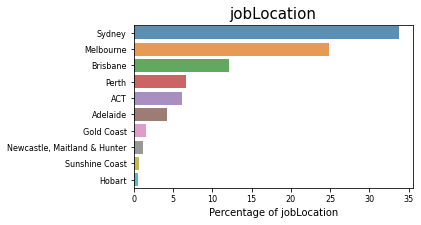

In [12]:
bargraph_var(df, 'jobLocation')

In [13]:
#function to change location that is not a major city into the 'Other' category
def condense_jobLocation(x):
    #list of major cities
    cities= ['Sydney', 'ACT','Perth', 'Melbourne', 'Brisbane', 'Adelaide', 'Hobart', 'Darwin']
    
    location=str(x)
    new_loc= None
    
    #check if location is in the list of major cities
    if location in cities:
        #if yes, we keep the location name as is
        new_loc= location
    else:
        #if no, we recategorize it as Others
        new_loc= 'Others'
    return new_loc

In [14]:
#apply the condense_jobLocation function to our jobLocation column
df['jobLocation']= df['jobLocation'].apply(lambda x : condense_jobLocation(x))

In [15]:
#chech the new distribution of our jobLocation column
df.jobLocation.value_counts(normalize=True)

Sydney       0.338092
Melbourne    0.248959
Brisbane     0.121336
Others       0.110715
Perth        0.066276
ACT          0.061942
Adelaide     0.042230
Hobart       0.005608
Darwin       0.004843
Name: jobLocation, dtype: float64

###### III.3.i- 2 Industry and Industry_details

The Information and Technology dominates in terms of the number of jobs listed under this industry. This is understandable as this Industry has been most prominent in the application of data science. We can see that Administration & Office Support follows closely. However, upon further inspection, we notice that majority of the roles represented in this category refer to data entry jobs which is not part of the scope of this project. Hence, we will drop these rows. There are also a couple of Trades-related jobs that deal more with the daily operations in a data centre rather than any data-related jobs. We will also be dropping these rows. 


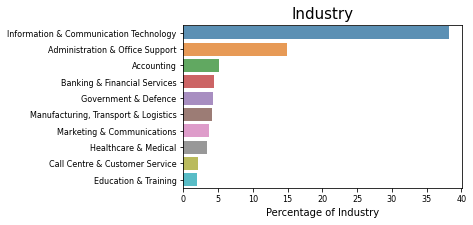

In [16]:
bargraph_var(df, 'Industry')

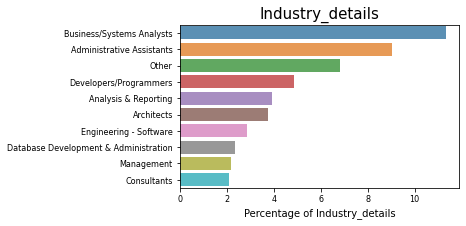

In [17]:
bargraph_var(df, 'Industry_details')

In [18]:
#drop all Data Entry and Admin Assistant jobs
df=df[~(df['jobTitle'].str.title().str.contains('Data Entry') | (df['jobTitle'].str.title().str.contains('Admin') & df['jobTitle'].str.title().str.contains('Assistant')))]
#drop all Trades Industry as these are not data-science related jobs
df= df[~df['Industry'].str.title().str.contains('Trade')]
df= df[~df['Industry_details'].str.title().str.contains('Administrative Assistants')]

In [19]:
print('The shape of the df after dropping Admin and Trades industries is', df.shape)

The shape of the df after dropping Admin and Trades industries is (10336, 7)


###### III.3.i- 3 Worktype2

This column does not require any processing. From the graph below, we can see that Full-time jobs comprise 60% of our dataset. However, as this is not our main predictor, we do not need to rebalance this

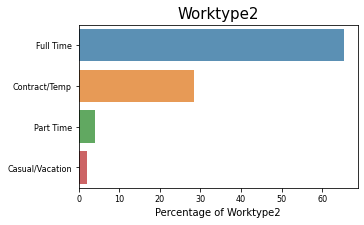

In [20]:
bargraph_var(df, 'Worktype2')

###### III.3.i-3 jobTitle

The jobTitle variable is both a predictor for our Salary_range prediction as well as our target variable for our second objective. 

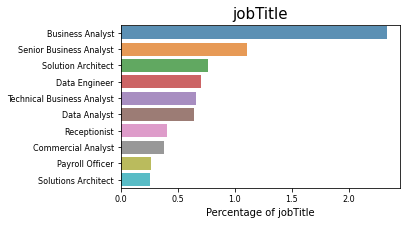

In [21]:
bargraph_var(df, 'jobTitle')

In [22]:
len(df.jobTitle.unique())

7286

Job Titles are often written differently per job advertiser. There could multiple ways that a title is made more specific to what the company needs. Looking at our jobTitles, we can see that there are 7276 unique job titles in our dataset. We want to condense these job titles into the five categories we specified in our job scope. We will categorize similar roles into main categories. For example, in general, the role of a Data Scientist has most similarity to a Researcher; hence, Researchers will be recategorized into Scientist main category. In the interest of keeping the number of classes to 5 and below, we will combine together Data Engineer, Architect, and Developer into one category. 

All jobs that do not fall within these categories are dropped. We will be using the following functions to recategorize our jobTitles into our 5 main classes.

In [23]:
#function to recategorize jobTitles into 5 main classes. 
def condense_jobTitles(x):
    #we lumped together closely related roles into the main categories. 
    scientist_kw= ['Science', 'Scientist', 'Model', 'Researcher', 'Consultant', 'Specialist', 'PhD', 'Advisor', 'Research']
    engineer_kw=['Engineer', 'Oracle', 'Database','Developer', 'Software', 'Programmer', 'Dev', 'Architect', 'Designer']
    manager_kw= ['Manager', 'Product', 'Executive', 'Head', 'Director']
    #business analyst and data analyst categories
    
    title=str(x).title()
    new_title= None
    if (any(word in title for word in scientist_kw) | (('Lead' in title) & (('Analyst' not in title)| ('Analytics' not in title)))):
        new_title= 'Scientist'
    elif (('Business' not in title) & (('Analyst' in title) | ('Analytics' in title))):
        new_title='Analyst'
    elif (('Business' in title) & ('Analyst' in title)):
        new_title= 'Business Analyst'
    elif any(word in title for word in engineer_kw):
        new_title= 'Engineer'
    elif any(word in title for word in manager_kw):
        new_title= 'Manager'
    else:
        new_title=None
    return new_title

In [24]:
#apply function to the whole df
df['jobTitle']= df['jobTitle'].apply(lambda x : condense_jobTitles(x))
#drop nulls
df = df[df['jobTitle'].notna()]

In [25]:
#below shows the new distribition of our jobTitles
df.jobTitle.value_counts(normalize=True)

Scientist           0.239238
Analyst             0.234576
Engineer            0.223608
Business Analyst    0.160132
Manager             0.142446
Name: jobTitle, dtype: float64

Our df is made smaller due to dropping the unrelated jobs. 

In [26]:
print('The shape of the df after dropping unrelated job titles is', df.shape)

The shape of the df after dropping unrelated job titles is (7294, 7)


###### III.3.i- 4 Salary_range

We currently have 5 buckets of Salary_range obtained through our scraping. However, this results in a dataset where one class is 25% less than another class. To even out our classes a bit, we will reduce our categories to 3 salary bins (low, mid, high). To do this, I will combine low with mid-low and high with mid-high. 

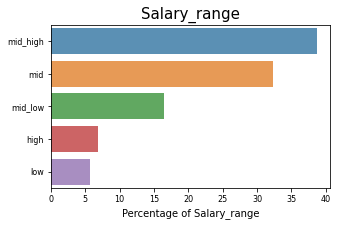

In [27]:
bargraph_var(df, 'Salary_range')

In [28]:
#combine low and mid-low, and high and mid-high to reduce the number of our classes
df.Salary_range.replace('mid_low', 'low', inplace=True)
df.Salary_range.replace('mid_high', 'high', inplace=True)

For easier interpretation, let's change the name of our categories into 0,1,2 corresponding to low, mid, and high.

In [29]:
df.Salary_range.replace('low', 0, inplace=True)
df.Salary_range.replace('mid', 1, inplace=True)
df.Salary_range.replace('high', 2, inplace=True)

In [30]:
df.Salary_range.value_counts(normalize=True)

2    0.455854
1    0.322868
0    0.221278
Name: Salary_range, dtype: float64

In [31]:
print('The shape of the df after dropping unnecessary columns is', df.shape)

The shape of the df after dropping unnecessary columns is (7294, 7)


##### III.3.ii Separate our predictors and targets, Train-test split

We now have our final clean dataframe. From here, we extract our X and y variables. We will extract two sets of X, y variables based on the two goals we have. Then, we will split our data into train and test data.

##### III.3.ii-1 Salary_range Prediction data

In [32]:
#for Salary_range prediction, our X,y variables are below. 
X= df.drop('Salary_range',axis=1).copy()
y= df['Salary_range'].copy()

In [33]:
#we split our train & test data for Salary_range prediction
oX_train, oX_test, y_train, y_test= train_test_split(X,y, random_state= 42, stratify=y)

In [34]:
#we reset the indices
oX_train.reset_index(drop=True, inplace=True)
oX_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [35]:
oX_train.shape, y_train.shape, oX_test.shape, y_test.shape

((5470, 6), (5470,), (1824, 6), (1824,))

##### III.3.ii-2 JobTitle Prediction data

In [36]:
#for jobTitle prediction, our X,y variables are below.
X2= df.jobAdDetails.copy()
y2= df.jobTitle.copy()

In [37]:
#we split our train & test data for jobTitle prediction
oX2_train, oX2_test, y2_train, y2_test= train_test_split(X2,y2, random_state= 42, stratify=y2)

In [38]:
#we reset the indices
oX2_train.reset_index(drop=True, inplace=True)
oX2_test.reset_index(drop=True, inplace=True)
y2_train.reset_index(drop=True, inplace=True)
y2_test.reset_index(drop=True, inplace=True)

In [39]:
oX2_train.shape, y2_train.shape, oX2_test.shape, y2_test.shape

((5470,), (5470,), (1824,), (1824,))

### IV. Salary Range Prediction
---

#### IV-1. Methodology
---

We will be using tokenisation in order to extract the features from our jobAdDetails column. Simply put, tokenisation is the process of breaking raw text (in our case, the jobadDetails into small pieces. For Salary_range prediction, we will make use of CountVectorizer from SKLearn to transform our text into a vector of token counts- note that CountVectorizer uses a form of word tokeniser to tokenise texts. 

As the remaining columns are also object type, we will create dummies for these columns then merge this with our tokenised text to come up with our final predictor matrix. 

As our target variable is the Salary_range, the question can be solved using classification models. We will use the following models and check which one will give us the best performance:
    1. Logistic Regression
    2. NaiveBayes Classifier
    3. Decision Tree
    4. Random Forest
    5. Extra Tree Classifier



##### IV-1.i. CountVectorizer

We would like to keep our data as compact as possible, we do not want any unnecessary data using up processing time and adding complication to our model. One way to do this is by making sure that we remove words that will not contribute or add signal. One major group of words that we can remove from our data are the commonly used words such as ('the', 'a', 'an'). These group of words are commonly referred to as stop words. SKLearn already has a list of stop words in the english language compiled. However, in CountVectorizer, we can further expand this list by creating our own custom stop words. Hence, for this project, we created our own stop words that includes the standard stop words as well as words that are featured heavily in the texts but does not add predictive value. 

In [40]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords

custom_stop_words = list(ENGLISH_STOP_WORDS)
custom_stop_words.extend(stopwords.words('english'))
custom_stop_words.extend(['data', 'analyst', 'analysts','scientist', 'science','engineer','architect', 'manager', 
                          'projects','processes', 'button', 'key', 'scientists','organisation', 'resume', 'resumes'
                          'analyst','customer', 'director', 'techniques','contact','apply','models', 'engineering', 
                          'developer', 'solutions', "qualifications", 'skills', 'labratory'])


As additional means to reduce dimensionality of our data, we will also make sure of the max_df and min_df arguments. We set our max_df to 0.8 which means that we will remove words that appear in 80% of our job Ads. Meanwhile, we set our min_df to 20 which means that words that appear in less than 20 of our job Ads will also not be included. 

It is also important to understand that analyses of texts need to take into account the relationships between words. To account for some relationships, we will also consider which words tend to follow others immediately, or that tend to co-occur within the same documents. For this we will make use of the argument n-grams in the CountVectrorizer. We will set our n-grams range to (1,2) which means that we will also be looking at pairs of words. 

We will also limit dimensionality by limiting the actual number of features to create using the max_features argument. We will be limiting ours to 2500. Note that we will merge this to our dummied columns, hence our predictor matrix dimension will still expand. 

In [41]:
cvec= CountVectorizer(strip_accents='unicode', 
                      stop_words=custom_stop_words,
                      lowercase= True,
                      max_df=0.8,
                      min_df= 50,
                     max_features=2500, ngram_range= (1,2), token_pattern='(?u)\\b\\w\\w{5,}\\b')

In [42]:
# we take our jobAdDetails from our oX_train to fit into our Vectorizer. 
dtm_train= oX_train.jobAdDetails
dtm_test=oX_test.jobAdDetails

#we fit this into our Vectorizer
cvec.fit(dtm_train)

# and check out the length of the vectorized data after
len(cvec.get_feature_names())

2500

In [43]:
#we create our document term matrices for our train and test dataset.
Xdtm_train = pd.DataFrame(cvec.transform(dtm_train).todense(),
                       columns=cvec.get_feature_names())
Xdtm_test= pd.DataFrame(cvec.transform(dtm_test).todense(),
                       columns=cvec.get_feature_names())

##### IV.1.ii. Dummy our other variables

Next we move to creating dummies for our other variables. 

In [44]:
dummies_train=pd.get_dummies(data=oX_train.drop('jobAdDetails', axis=1), columns=list(oX_train.drop('jobAdDetails', axis=1).columns), drop_first=True)
dummies_test=pd.get_dummies(data=oX_test.drop('jobAdDetails', axis=1), columns=list(oX_test.drop('jobAdDetails', axis=1).columns), drop_first=True)

In [45]:
#we need to make sure that we are aligning the dummies in our test data based on our train dataset. hence we use the .align function
dummies_train, dummies_test = dummies_train.align(dummies_test, join='left', axis=1)

#if there are features in our train data not found in our test data, due to aligning, we will have nulls in those columns
#we will then put 0 as the value for those nulls
dummies_test.fillna(0,inplace=True)


In [46]:
# Next, we will merge our document term matrices with our dummied variables to have our final train test set.
X_train= dummies_train.merge(Xdtm_train,left_index=True, right_index=True)
X_test= pd.merge(dummies_test, Xdtm_test, left_index=True, right_index=True)

In [47]:
#let's check if our datasets match in size
X_train. shape, y_train.shape, X_test.shape, y_test.shape

((5470, 2758), (5470,), (1824, 2758), (1824,))

##### IV.1.iii. Standardise

To make sure that all columns are in the same scale, we will use the StandardScale() preprocessing in SKLearn to standardise our dataset. Note that we will fit this transformer onl;y with our train dataset. 

In [48]:
ss= StandardScaler()
Xs_train= ss.fit_transform(X_train)
Xs_test= ss.transform(X_test)

#### IV-2. Data and Analysis
---
Now that we have our clean,split, processed, and standardised datasets, we are ready to run our models. We will be comparing the performances of the following five models and choose our best performer. 
1. Logistic Regression
2. Naive Bayes Classifier
3. Decision Tree Classifier
4. Random Forest Classifier
5. Extra Tree Classifier

While accuracy is a good way to determine how good our model is, this will not be our only measure for performance. We will be looking at multiple metrics to assess performance of the models including accuracy, precision, recall, and the ROC-AUC. To be able to do that, we will use the following functions. 

In [49]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

#create confusion matrix to visualize performance of our data against actual values. We will be using this forboth questions
#hence, we have an argument to choose which question it is for so we can customize the labels. 
def plot_confusion_matrix(cm, question=1,size=(6,6),
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    #customising labels depending on question being answered (1. Salary_range, 2. JobTitle)
    if question==1:
        classes=['low', 'mid', 'high']
    elif question==2:
        classes=['Analyst', 'Business Analyst', 'Engineer', 'Manager', 'Scientist']
    plt.figure(figsize=size)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.tight_layout()

In [50]:
from sklearn.metrics import roc_curve, auc

#plot our ROC for every class. This is a one vs rest plot for every class in our target
def plot_multiclass_roc(score, test, n_classes, figsize=(17, 6), model='classifier model'):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    test_dummies = pd.get_dummies(test, drop_first=False).values
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_dummies[:, i], score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(('Receiver operating characteristic for '+ model))
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

In [86]:
#function to create wordcloud to visualize our coefficients
from wordcloud import WordCloud
def create_wordcloud(df):
    #coefficient dataframe
    bag= df.copy()
    
    #we will only use the variable names and coefficent, hecne we will drop the abs_coef column
    bag.drop('abs_coef', axis=1, inplace=True)
    
    #we will put the variables names and the corresponding cofficients in a dictionary
    d = {}
    for a, x in bag.values:
        d[a] = x

    #create our wordcloud    
    wordcloud = WordCloud(colormap='copper', background_color='white')
    wordcloud.generate_from_frequencies(frequencies=d)
    
    #format our image
    plt.figure(figsize=(10,5))
    plt.imshow(wordcloud, interpolation='bilinear', cmap='Pastel2')
    plt.axis("off")
    
    #show wordcloud
    plt.show()

In [52]:
#create a dataframe for summary of results to make comparison easier
results_Salary_range= pd.DataFrame(columns=['model', 'train_accuracy', 'test_accuracy', 'ave_precision', 'ave_recall', 'ave_AUC'])

##### IV-2.0. Baseline

Our baseline is the % of our majority class which is the high salary band (labelled 2) at 45%

In [53]:
y.value_counts(normalize=True)

2    0.455854
1    0.322868
0    0.221278
Name: Salary_range, dtype: float64

##### IV-2-i. Logistic Regression

In [54]:
#initialize our model and fit it with our train data
lr1 = LogisticRegressionCV(max_iter=200, solver= 'liblinear', cv=3, n_jobs=-1, verbose=1)
lr1.fit(Xs_train, y_train)

#we will score our 
lr1.score(Xs_test, y_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:  1.8min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:  2.3min finished


0.7231359649122807

In [55]:
#score our model on our train and test data, record the score in a variable
lr1_train_score=lr1.score(Xs_train, y_train)
lr1_test_score=lr1.score(Xs_test, y_test)

In [56]:
#get confidence scores for our test data
y_score_lr1= lr1.decision_function(Xs_test)

#get the predicted value for our test data
yhat_lr1=lr1.predict(Xs_test)

#create a classification report. the output is a dictionary which we can access
lr1_report= classification_report(y_test, yhat_lr1, output_dict=True)
print(classification_report(y_test, yhat_lr1))

              precision    recall  f1-score   support

           0       0.68      0.63      0.65       404
           1       0.67      0.64      0.66       589
           2       0.77      0.83      0.80       831

    accuracy                           0.72      1824
   macro avg       0.71      0.70      0.70      1824
weighted avg       0.72      0.72      0.72      1824



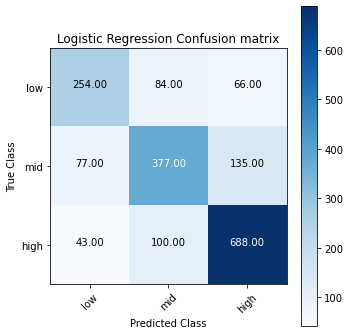

In [57]:
#we will create the confusion matrix as per the function shown earlier
cm_lr1 = confusion_matrix(y_test, yhat_lr1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_lr1,size=(5,5),title='Logistic Regression Confusion matrix')

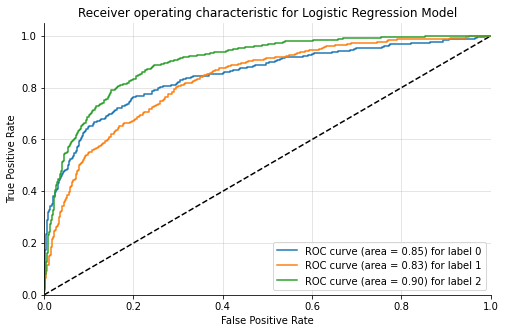

In [58]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_lr1,y_test,3, (8,5), model='Logistic Regression Model')

Based on the above, our model is performing well against the baseline. The model has improved performance against baseline by 0.27. As expected due to it being the majority class, the model is performing best with label 2 as shown in our ROC area under the curve where label 2 has an area of 0.91. The same can be said of its performance with precision and recall. However, it is suprising to see that the model is performing less effectively (only when compared to the other two classes) for label 1 despite it having more datapoints in our training set compared to label 0 (low salary bin). This can be due to the label 1(mid salary band) being the intermediate state between the two salary bins. 

In [59]:
#get our average AUC
lr1_auc= (0.85+0.83+0.90)/3

#summarize the performance metrics for lr1 model
results_lr1= pd.Series({'model': 'Logistic Regression',
                        'train_accuracy': lr1_train_score,
                        'test_accuracy': lr1_test_score,
                        'ave_precision': lr1_report['weighted avg']['precision'],
                        'ave_recall': lr1_report['weighted avg']['recall'],
                        'ave_AUC': lr1_auc })

#add this is our summary df for easier comparison later
results_Salary_range.loc[0]= results_lr1
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.86


##### IV-2-ii. Naive Bayes

We will be using BernoulliNB model as it is known to perform better for multiclass discrete targets which is a characteristic of our target.

In [60]:
#initialize our model and fit & score it with our train data using cross validation
nb= BernoulliNB()
nb1_train_score= np.mean(cross_val_score(nb, Xs_train, y_train, cv=3, n_jobs=-1, verbose=1))
print('NB train score is:', nb1_train_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


NB train score is: 0.6314433144710377


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.8s finished


In [61]:
#score model with our test data
nb1_test_score=nb.fit(Xs_train, y_train).score(Xs_test, y_test)
print("NB test score is:", nb1_test_score)

NB test score is: 0.637609649122807


In [62]:
#get confidence scores for our test data
y_score_nb= nb.predict_proba(Xs_test)

#get the predicted value for our test data
yhat_nb= nb.predict(Xs_test)

#create a classification report. the output is a dictionary which we can access
nb1_report= classification_report(y_test, yhat_nb, output_dict=True)
print(classification_report(y_test, yhat_nb))

              precision    recall  f1-score   support

           0       0.59      0.64      0.62       404
           1       0.56      0.52      0.54       589
           2       0.72      0.72      0.72       831

    accuracy                           0.64      1824
   macro avg       0.62      0.63      0.62      1824
weighted avg       0.64      0.64      0.64      1824



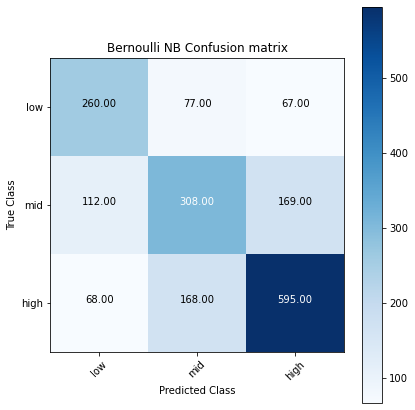

In [63]:
#we will create the confusion matrix as per the function shown earlier
cm_nb = confusion_matrix(y_test, yhat_nb)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_nb,title='Bernoulli NB Confusion matrix')

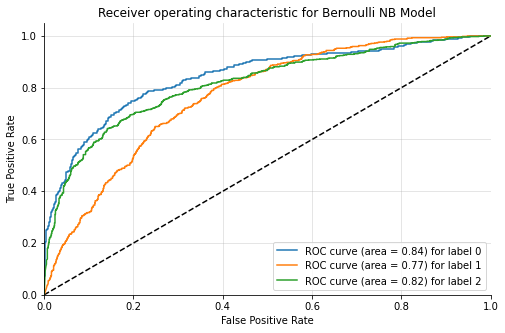

In [64]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_nb,y_test,3, (8,5), model='Bernoulli NB Model')

The Naive Bayes model is performing 18 points higher than our baseline with accuracy score of 0.64 for our test data. Unlike Logistic regression (LR), looking at the ROC curve, we can see that it performs best for label 0 (low salary). But same with LR, our NB model performs worst for label 1 (mid Salary). We summarize the performance metrics below)

In [65]:
#get our average AUC
nb1_auc= (0.84+0.77+0.82)/3

#summarize the performance metrics for nb model
results_nb1= pd.Series({'model': 'Naive Bayes',
                        'train_accuracy': nb1_train_score,
                        'test_accuracy': nb1_test_score,
                        'ave_precision': nb1_report['weighted avg']['precision'],
                        'ave_recall': nb1_report['weighted avg']['recall'],
                        'ave_AUC': nb1_auc })

#add this is our summary df for easier comparison later
results_Salary_range.loc[1]= results_nb1
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.86
1,Naive Bayes,0.631443,0.637610,0.636940,0.637610,0.81


##### IV-2-iii. Decision Tree

In [66]:
#initialize our model and fit & score it with our train data using cross validation
dt1= DecisionTreeClassifier(max_depth=None, max_features='auto')
dt1_train_score= np.mean(cross_val_score(dt1, Xs_train, y_train, cv=3, n_jobs=-1, verbose=1))
dt1_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


0.5460688714380576

In [67]:
#score model with our test data
dt1_test_score=dt1.fit(X_train, y_train).score(Xs_test, y_test)
dt1_test_score

0.5032894736842105

In [68]:
#get confidence scores for our test data
y_score_dt= dt1.predict_proba(Xs_test)

#get the predicted value for our test data
yhat_dt1= dt1.predict(Xs_test)

#create a classification report. the output is a dictionary which we can access
dt1_report= classification_report(y_test, yhat_dt1, output_dict=True)
print(classification_report(y_test, yhat_dt1))

              precision    recall  f1-score   support

           0       0.38      0.49      0.43       404
           1       0.46      0.46      0.46       589
           2       0.63      0.55      0.58       831

    accuracy                           0.50      1824
   macro avg       0.49      0.50      0.49      1824
weighted avg       0.52      0.50      0.51      1824



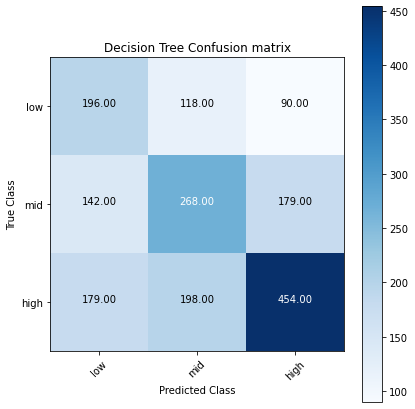

In [69]:
#we will create the confusion matrix as per the function shown earlier
cm_dt1 = confusion_matrix(y_test, yhat_dt1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_dt1,title='Decision Tree Confusion matrix')

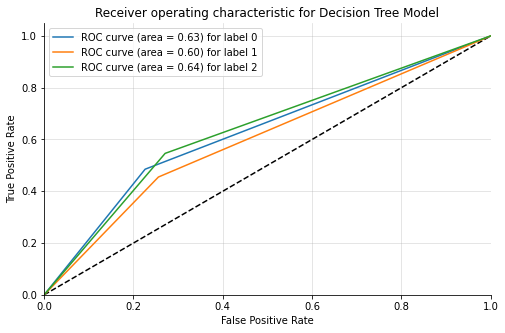

In [70]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_dt,y_test,3, (8,5), model='Decision Tree Model')

The Decision Tree model is performing 5 points better than our baseline for our test data. Its ROC curve shows that it doesn't perform significantly well for all classes, with it's False Positive rate moving in an almost linear fashion against its True Positive Rate.Performance metrics for this model is added to the results summary below.

In [71]:
#get our average AUC
dt1_auc= (0.62+0.60+0.63)/3

#summarize the performance metrics for dt1 model
results_dt1= pd.Series({'model': 'Decision Tree',
                        'train_accuracy': dt1_train_score,
                        'test_accuracy': dt1_test_score,
                        'ave_precision': dt1_report['weighted avg']['precision'],
                        'ave_recall': dt1_report['weighted avg']['recall'],
                        'ave_AUC': dt1_auc })

#add this is our summary df for easier comparison later
results_Salary_range.loc[2]= results_dt1
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.860000
1,Naive Bayes,0.631443,0.637610,0.636940,0.637610,0.810000
2,Decision Tree,0.546069,0.503289,0.518241,0.503289,0.616667


##### IV-2-iv. Random Forest

In [72]:
#initialize our model and fit & score it with our train data using cross validation
rfc1= RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='auto', oob_score=True)
rfc1_train_score= np.mean(cross_val_score(rfc1, Xs_train, y_train, cv=3, n_jobs=-1, verbose=1))
rfc1_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   31.4s finished


0.7168195619328078

In [73]:
#score model with our test data
rfc1_test_score= rfc1.fit(Xs_train, y_train).score(Xs_test, y_test)
rfc1_test_score

0.7406798245614035

In [74]:
#get confidence scores for our test data
y_score_rfc1= rfc1.predict_proba(Xs_test)


#get the predicted value for our test data
yhat_rfc1= rfc1.predict(Xs_test)

#create a classification report. the output is a dictionary which we can access
rfc1_report= classification_report(y_test, yhat_rfc1, output_dict=True)

print(classification_report(y_test, yhat_rfc1))

              precision    recall  f1-score   support

           0       0.84      0.51      0.63       404
           1       0.68      0.71      0.69       589
           2       0.75      0.88      0.81       831

    accuracy                           0.74      1824
   macro avg       0.76      0.70      0.71      1824
weighted avg       0.75      0.74      0.73      1824



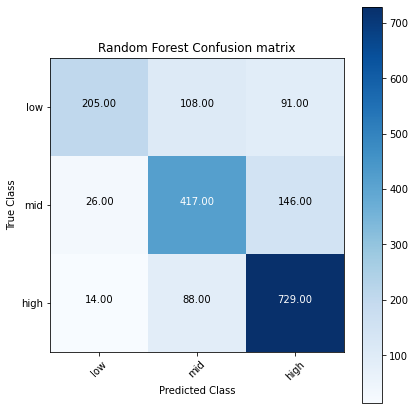

In [75]:
#we will create the confusion matrix as per the function shown earlier
cm_rfc1 = confusion_matrix(y_test, yhat_rfc1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_rfc1,title='Random Forest Confusion matrix')

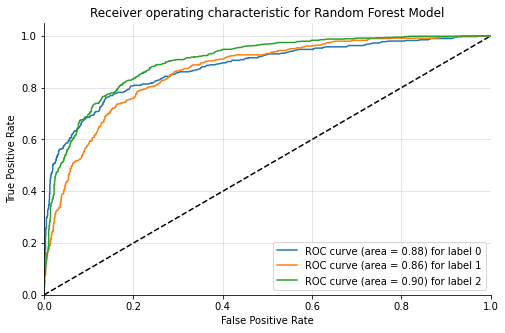

In [76]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_rfc1,y_test,3, (8,5), model='Random Forest Model')

The Random Forest model is outperforming the baseline by almost 19 points for our test data. Similar to Logistic regression (LR), looking at the ROC curve, we can see that it performs best for label 2 (high salary) which is our majority class. But contrary to earlier models, our RFC model performs relatively well across all 3 classes. Looking at the precision, the model is performing extremely well for label 0. However, recall metric says the opposite, we can see that this model is performing better for labels 1&2 compared to label 0. To see account for both, we look at our F1-score which shows the harmonic mean of precision and recall.The F1-score clearly shows the model performing better for labels 1&2 than with label 0.

A summary of performance metrics is shown below.

In [77]:
#get our average AUC
rfc1_auc= (0.88+0.86+0.90)/3

#summarize the performance metrics for rfc1 model
results_rfc1= pd.Series({'model': 'Random Forest',
                        'train_accuracy': rfc1_train_score,
                        'test_accuracy': rfc1_test_score,
                        'ave_precision': rfc1_report['weighted avg']['precision'],
                        'ave_recall': rfc1_report['weighted avg']['recall'],
                        'ave_AUC': rfc1_auc })

#add this is our summary df for easier comparison later
results_Salary_range.loc[3]= results_rfc1
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.860000
1,Naive Bayes,0.631443,0.637610,0.636940,0.637610,0.810000
2,Decision Tree,0.546069,0.503289,0.518241,0.503289,0.616667
3,Random Forest,0.716820,0.740680,0.748813,0.740680,0.880000


##### IV-2-v. Extra Tree

In [78]:
#initialize our model and fit & score it with our train data using cross validation
et1= ExtraTreesClassifier(n_estimators=1000)
et1_train_score= np.mean(cross_val_score(et1, Xs_train, y_train, cv=3, n_jobs=-1, verbose=1))
et1_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   46.3s finished


0.72998106552723

In [79]:
#score model with our test data
et1_test_score= et1.fit(Xs_train, y_train).score(Xs_test, y_test)
et1_test_score

0.7478070175438597

In [80]:
#get confidence scores for our test data
y_score_et1= et1.predict_proba(Xs_test)


#get the predicted value for our test data
yhat_et1= et1.predict(Xs_test)

#create a classification report. the output is a dictionary which we can access
et1_report= classification_report(y_test, yhat_et1, output_dict=True)

print(classification_report(y_test, yhat_et1))

              precision    recall  f1-score   support

           0       0.82      0.56      0.67       404
           1       0.69      0.70      0.69       589
           2       0.76      0.87      0.81       831

    accuracy                           0.75      1824
   macro avg       0.76      0.71      0.73      1824
weighted avg       0.75      0.75      0.74      1824



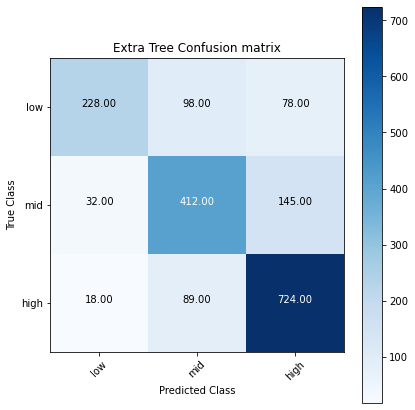

In [81]:
#we will create the confusion matrix as per the function shown earlier
cm_et1 = confusion_matrix(y_test, yhat_et1)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_et1,title='Extra Tree Confusion matrix')

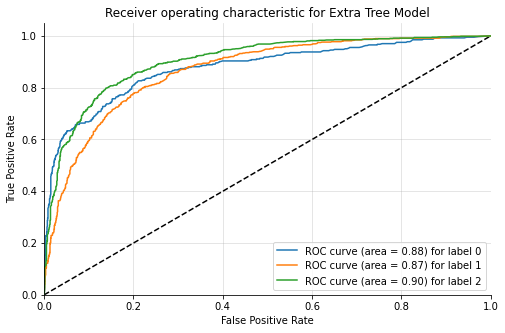

In [82]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_et1,y_test,3, (8,5), model='Extra Tree Model')

The Random Forest model is outperforming the baseline by 20 points for our test data. Similar to RFC, looking at the ROC curve, we can see that it performs best for label 2 (high salary) which is our majority class and it performs relatively well across all 3 classes.  

Similar to RFC, the model has excellent precision score for label 0. However, recall metric says the opposite, we can see that this model is performing better for labels 1&2 compared to label 0. We can see that Extra Tree has improved the label 0 recall score and label 0 F1-score by a significant margin.

To see account for both, we look at our F1-score which shows the harmonic mean of precision and recall.The F1-score clearly shows the model performing better for labels 1 than with label 0&1.

A summary of performance metrics is shown below.

In [83]:
#get our average AUC
et1_auc= (0.88+0.86+0.90)/3

#summarize the performance metrics for et1 model
results_et1= pd.Series({'model': 'Extra Tree',
                        'train_accuracy': et1_train_score,
                        'test_accuracy': et1_test_score,
                        'ave_precision': et1_report['weighted avg']['precision'],
                        'ave_recall': et1_report['weighted avg']['recall'],
                        'ave_AUC': et1_auc })

#add this is our summary df for easier comparison later
results_Salary_range.loc[4]= results_et1
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.860000
1,Naive Bayes,0.631443,0.637610,0.636940,0.637610,0.810000
2,Decision Tree,0.546069,0.503289,0.518241,0.503289,0.616667
3,Random Forest,0.716820,0.740680,0.748813,0.740680,0.880000
4,Extra Tree,0.729981,0.747807,0.752070,0.747807,0.880000


#### IV-2. Results and Findings
---

The Extra Tree Classifier performed best against the other 4 Classifiers although not by a wide margin. With a Baseline of 0.45, the Extra Tree Classifier performed 30 points above baseline (accuracy score of 0.75). Random Forest and Logistic Regression also perfomed well on this dataset as shown in the summary table below. Extra Tree edges our other classifiers across all metrics considered.

In [84]:
results_Salary_range

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression,0.886472,0.723136,0.720013,0.723136,0.860000
1,Naive Bayes,0.631443,0.637610,0.636940,0.637610,0.810000
2,Decision Tree,0.546069,0.503289,0.518241,0.503289,0.616667
3,Random Forest,0.716820,0.740680,0.748813,0.740680,0.880000
4,Extra Tree,0.729981,0.747807,0.752070,0.747807,0.880000


To answer the question of what words affect Salary range, we can look at the coefficients for this model (as shown below). Full-time and Contract work types have the biggest impact on Salary. Manager/Business Analyst/Engineer jobtitles are also words that affect our target. However, the model is not giving us the specific words that predict each class best. 

#### Coefficients from Extra Tree

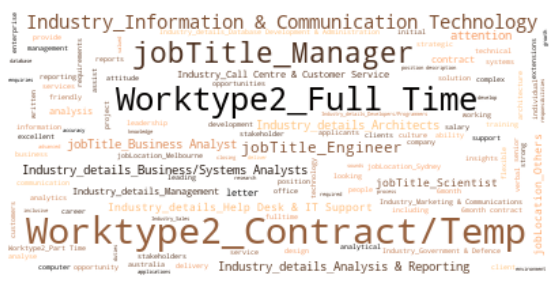

In [87]:
#obtain coefficients that determine how data is split into classes

#get coefs
coefs_et1= list(et1.feature_importances_)

#get absolute value of coefs for sorting
coefs_abs_et1=np.abs(coefs_et1)

#create df of coefs
output_et1 = pd.DataFrame({'variable':X_train.columns,
                            'coef':coefs_et1,
                            'abs_coef':coefs_abs_et1})

#sort based on coef values
output_et1.sort_values('abs_coef', inplace=True, ascending=False)

#create a word cloud for this list of coefficients using the create_wordcloud we created
create_wordcloud(output_et1)

In [88]:
#Run code below to show the top 20 words that affect Salary range
# output_et1.head(20)

The coefficients we get from Extra Tree is only giving us the words that best affect how we subdivided into our classes. To see which words best define each class, we can look at the coefficients we get from our Logistic Regression model. Note that our LR model is not lagging behind Extra Tree in performance across all metrics and is performing way better than our Baseline. To see coefficients for each Salary range, please see below. 

For low salary, we can infer based on coefficients that these are jobs that involve Help Desk and Customer-support centric jobs. We can also see that these are graduate/associate/junior roles. Part-time roles are also likely to be in the lower salary range. 

For mid-salary range, Full time work are likely to be in the mid-salary range. Business Analyst roles and roles in the Government are also likely to be in this range. In terms of skills, to get a job in this range, one needs python, analysis, optimsation, and reporting.

High salary range are likely to be Contract type. These include Manager and Engineer roles. Senior and executive roles are also likely to fall within this range. Jobs that require skills/qualities such as leaderhip, negotiation, and strategic are also likely to be in this range.

#### Coefficients from Logistic Regression for each Salary range

In [89]:
#obtain coefficients for low salary range (label 0)

#get coefs
coefs_lr1_low= list(lr1.coef_[0])

#get absolute value of coefs for sorting
coefs_abs_lr1_low=np.abs(coefs_lr1_low)

#create df of coefs
output_lr1_lowSalary = pd.DataFrame({'variable':X_train.columns,
                            'coef':coefs_lr1_low,
                            'abs_coef':coefs_abs_lr1_low})

#sort based on coef values
output_lr1_lowSalary.sort_values('coef', inplace=True, ascending=False)

#show the top 30 words
output_lr1_lowSalary.head(30)

,variable,coef,abs_coef
132,Industry_details_Help Desk & IT Support,0.186730,0.186730
16,Industry_Call Centre & Customer Service,0.167594,0.167594
94,Industry_details_Customer Service - Call Centre,0.147497,0.147497
859,customers,0.147200,0.147200
257,Worktype2_Part Time,0.145153,0.145153
469,attitude,0.136149,0.136149
1380,graduate,0.135672,0.135672
467,attention,0.130248,0.130248
739,computer,0.117604,0.117604
204,Industry_details_Recruitment - Agency,0.111064,0.111064


In [90]:
#obtain coefficients for mid salary range (label 1)

#get coefs
coefs_lr1_mid= list(lr1.coef_[1])

#get absolute value of coefs for sorting
coefs_abs_lr1_mid=np.abs(coefs_lr1_mid)

#create df of coefs
output_lr1_midSalary = pd.DataFrame({'variable':X_train.columns,
                            'coef':coefs_lr1_mid,
                            'abs_coef':coefs_abs_lr1_mid})

#sort based on coef values
output_lr1_midSalary.sort_values('coef', inplace=True, ascending=False)

#show the top 30 words
output_lr1_midSalary.head(30)

,variable,coef,abs_coef
256,Worktype2_Full Time,0.095481,0.095481
97,Industry_details_Database Development & Admini...,0.080380,0.080380
0,jobTitle_Business Analyst,0.062492,0.062492
533,better,0.057950,0.057950
47,Industry_details_Analysis & Reporting,0.055392,0.055392
68,Industry_details_Business/Systems Analysts,0.051578,0.051578
2668,valued,0.043898,0.043898
1842,optimisation,0.043285,0.043285
1527,insights,0.039900,0.039900
395,analysis,0.039662,0.039662


In [91]:
#obtain coefficients for high salary range (label 2)

#get coefs
coefs_lr1_high= list(lr1.coef_[2])

#get absolute value of coefs for sorting
coefs_abs_lr1_high=np.abs(coefs_lr1_high)

#create df of coefs
output_lr1_highSalary = pd.DataFrame({'variable':X_train.columns,
                            'coef':coefs_lr1_high,
                            'abs_coef':coefs_abs_lr1_high})

#sort based on coef values
output_lr1_highSalary.sort_values('coef', inplace=True, ascending=False)

#show the top 30 words
output_lr1_highSalary.head(30)

,variable,coef,abs_coef
2,jobTitle_Manager,0.151983,0.151983
255,Worktype2_Contract/Temp,0.120121,0.120121
143,Industry_details_Management,0.073903,0.073903
1,jobTitle_Engineer,0.065761,0.065761
1615,leadership,0.064153,0.064153
28,Industry_Information & Communication Technology,0.061092,0.061092
2333,senior,0.059181,0.059181
49,Industry_details_Architects,0.057584,0.057584
33,"Industry_Mining, Resources & Energy",0.051103,0.051103
1662,looking senior,0.047746,0.047746


### V. Job Title Prediction
---

#### V.1. Methodology
---

For the Job Title prediction, we will only be using the jobAdDetails column. We will use and compare two types of feature extractor that implements word tokenisation: 1) CountVectorizer, 2) TfidfVectorizer. 

For modelling, we will use the following models for each of our Vectorizer:
1. Logistic Regression (with l2 penalty)
2. Extra Tree Classifier
3. Stochastic Gradient Descent Classifier 

This will give us a total of 6 Vectorizer-Classifier model combination to compare. 

Similar to the Salary_range prediction, we will be using some custom stop words to reduce dimensionality of our data. Below are the stop words we will use. Note that our targets may be found in the job Ad Details; hence, we will try to avoid leakage by including our target classes in our stop words.

In [92]:
custom_stop_words2 = list(ENGLISH_STOP_WORDS)
custom_stop_words2.extend(stopwords.words('english'))
custom_stop_words2.extend(['data', 'analyst', 'analysts','scientist', 'science','engineer','architect', 'manager', 
                          'projects','processes', 'button', 'key', 'scientists','organisation', 'resume', 
                           'resumes', 'analyst','customer', 'director', 'techniques','contact','apply','models', 
                           'engineering','developer', 'solutions', "qualifications", 'skills', 'labratory', 
                           'demonstrating', 'analysing', 'analyse'])

###### V.1.i. CountVectorizer
---

As with our Salary_range prediction, we will use CountVectorizer to create our document term matrix(dtm). However, unlike Salary_range prediction, we will be solely using our dtm (no added dummied variables) as our predictor matrix. As with normal modelling practice, we will fit-transform our vectorizer with our train data and only transform our test data. Then we will use StandardScale function to standardise our data as shown below.

As in Salary range prediction, we will limit dimensionality by specifying the following parameters:
1. stop_words: we again have created our custom stop_words that uses SKLearn stop words as base then expanded with NLTK stop words and cutom list of stop words we determined based on investigation of our jobAdDetails. These custom words include our actual target variables which sometimes appear in the document. 
2. max_df: we set this to words that appear in 50% of the documents as our max class is only 24%. Words that appear in 50% of documents will not be able to give us a good signal in differentiating the 5 classes. 
3. mind_df:  to reduce sparsity in columns, we will not include words that only appear in 10 documents or less. 
4. max_features: we will only use the top 2500 words

Also, to be able to account for relationship of words with other surrounding words, we will specify our n_grams to up to 2, which means that will also include pairs of words that appear together. 

###### V.1.i.1- Create DTM

In [93]:
#initialize our CountVectorizer with specific paramaters we require. 
cvec2= CountVectorizer(strip_accents='unicode',
                      stop_words=custom_stop_words2,
                      lowercase= True,
                      max_df=0.5,
                      min_df= 10,
                     max_features=2500, ngram_range= (1,2), token_pattern='(?u)\\b\\w\\w{5,}\\b')

In [94]:
#fit our vectorizer with our train data
cvec2.fit(oX2_train)
# and check out the length of the vectorized data after
len(cvec2.get_feature_names())

2500

In [95]:
#create our dtm_train
X2dtm_train = pd.DataFrame(cvec2.transform(oX2_train).todense(),
                       columns=cvec.get_feature_names())

#create our test_dtm
X2dtm_test= pd.DataFrame(cvec.transform(oX2_test).todense(),
                       columns=cvec2.get_feature_names())

###### V.1.i.2- Standardise

In [96]:
#initialize our Scaler
ss2= StandardScaler()

#fit_trasnform our train data
X2s_train= ss.fit_transform(X2dtm_train)

#transform our test data
X2s_test= ss.transform(X2dtm_test)

In [97]:
X2s_train.shape, y2_train.shape, X2s_test.shape, y2_test.shape

((5470, 2500), (5470,), (1824, 2500), (1824,))

###### V.1.ii. TfidfVectorizer
---

We will be comparing the performance of CountVectorizer with the Tfidf Vectorizer. As in CountVectorizer, we will be using the same custom stop_words. We will also set the max_df and max_features similar to the CountVectorizer. 

###### V.1.ii. TfidfVectorizer
---

In [98]:
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer

#initialize our vectorizer
my_vect= TfidfVectorizer(stop_words=custom_stop_words2,
                                      sublinear_tf=True,
                                      max_df=0.5,
                                      max_features=2500)
#fit with our train data
my_vect.fit(oX2_train)
# and check out the length of the vectorized data after
len(my_vect.get_feature_names())

2500

In [99]:
#create our train dtm
tfidf_train = pd.DataFrame(my_vect.transform(oX2_train).todense(),
                       columns=my_vect.get_feature_names())

#create our test dtm
tfidf_test= pd.DataFrame(my_vect.transform(oX2_test).todense(),
                       columns=my_vect.get_feature_names())

###### V.1.ii.2- Standardise

Similar to what we've done in the other models, we also use the StandardScaler to standardise our dtm. 

In [100]:
#initialize our Scaler
ss3= StandardScaler()

#fit transform our train data
X3s_train= ss3.fit_transform(tfidf_train)

#transform our test data
X3s_test= ss3.transform(tfidf_test)

In [101]:
#check shape of our data to ensure that everything is aligned
X3s_train.shape, y2_train.shape, X3s_test.shape, y2_test.shape

((5470, 2500), (5470,), (1824, 2500), (1824,))

#### V.2. Data and Analysis
---
Now that we have our clean,split, processed, and standardised datasets, we are ready to run our models. We will be comparing the performances of the following combinations of vectorizers and models to choose our best performer:
1. CountVectorizer + Logistic Regression
2. CountVectorizer + Extra Tree Classifier
3. CountVectorizer + Stochastic Gradient Descent Classfier
4. TfidfVectorizer + Logistic Regression
5. TfidfVectorizer + Extra Tree Classifier
6. TfidfVectorizer + Stochastic Gradient Descent Classfier

While accuracy is a good way to determine how good our model is, this will not be our only measure for performance. We will be looking at multiple metrics to assess performance of the models including accuracy, precision, recall, and the ROC-AUC. 

##### V.2.0. Baseline

Our baseline is the % of our majority class which is the scientist class at 24%.

In [102]:
y2.value_counts(normalize=True)

Scientist           0.239238
Analyst             0.234576
Engineer            0.223608
Business Analyst    0.160132
Manager             0.142446
Name: jobTitle, dtype: float64

In [103]:
#create a dataframe for summary of results to make comparison easier
results_jobTitle= pd.DataFrame(columns=['model', 'train_accuracy', 'test_accuracy', 'ave_precision', 
                                        'ave_recall', 'ave_AUC'])


##### V.2.i. Logistic Regression with dtm created using CountVectorizer

In [104]:
#initialize our model and train model on our train data
lr2 = LogisticRegressionCV(penalty= 'l1', max_iter=200, solver= 'liblinear', cv=3, n_jobs=-1, verbose=1)
lr2.fit(X2s_train, y2_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  1.0min finished


LogisticRegressionCV(cv=3, max_iter=200, n_jobs=-1, penalty='l1',
                     solver='liblinear', verbose=1)

In [105]:
#score our model on our train and test data, record the score in a variable
lr2_train_score=lr2.score(X2s_train, y2_train)
lr2_test_score=lr2.score(X2s_test, y2_test)
print('LR2 Train Score:', lr2_train_score)
print('LR2 Test Score:', lr2_test_score)

LR2 Train Score: 0.8455210237659964
LR2 Test Score: 0.24780701754385964


In [106]:
#get confidence scores for our test data
y_score_lr2= lr2.decision_function(X2s_test)

#get the predicted value for our test data
yhat_lr2=lr2.predict(X2s_test)

#create a classification report. the output is a dictionary which we can access
lr2_report= classification_report(y2_test, yhat_lr2, output_dict=True)
print(classification_report(y2_test, yhat_lr2))

                  precision    recall  f1-score   support

         Analyst       0.27      0.17      0.21       428
Business Analyst       0.17      0.42      0.24       292
        Engineer       0.43      0.33      0.38       408
         Manager       0.20      0.13      0.16       260
       Scientist       0.25      0.19      0.22       436

        accuracy                           0.25      1824
       macro avg       0.26      0.25      0.24      1824
    weighted avg       0.28      0.25      0.25      1824



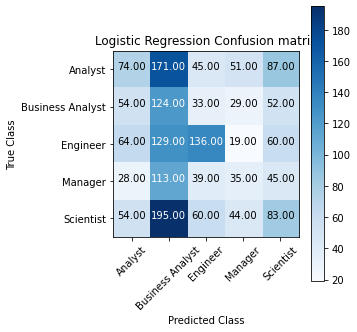

In [107]:
#we will create the confusion matrix as per the function shown earlier
cm_lr2 = confusion_matrix(y2_test, yhat_lr2)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_lr2,size=(5,5),question=2, title='Logistic Regression Confusion matrix')


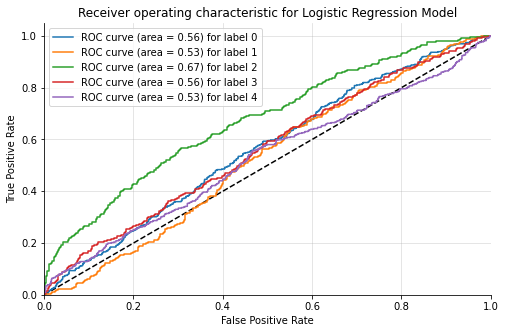

In [108]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_lr2,y2_test,5, (8,5), model='Logistic Regression Model')

This is an overfitted model easily inferred from looking at our train and test accuracy scores. The model has a very high accuracy with the train data and a very dismal accuracy with test data. It is not performing better than the baseline; hence, this is not a model we can deploy. Across all metrics with our test data, it's performance is dismal. Looking at the ROC curve, it is almost close to the middle line for all classes meaning that it is as likely to be correct as to be incorrect.

In [109]:
#get our average AUC
lr2_auc= (0.56+0.53+0.67+.56+.53)/5

#summarize the performance metrics for lr2 model
results_lr2= pd.Series({'model': 'Logistic Regression with CountVectorizer',
                        'train_accuracy': lr2_train_score,
                        'test_accuracy': lr2_test_score,
                        'ave_precision': lr2_report['weighted avg']['precision'],
                        'ave_recall': lr2_report['weighted avg']['recall'],
                        'ave_AUC': lr2_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[0]= results_lr2
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.57


##### V.2.ii. Extra Tree Classifier with dtm created using CountVectorizer

In [110]:
et2= ExtraTreesClassifier(n_estimators=1000)
et2_train_score= np.mean(cross_val_score(et2, X2s_train, y2_train, cv=3, n_jobs=-1, verbose=1))
et2_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   52.0s finished


0.6897601473055467

In [111]:
et2_test_score= et2.fit(X2s_train, y2_train).score(X2s_test, y2_test)
et2_test_score

0.2774122807017544

In [112]:
#get confidence scores for our test data
y_score_et2= et2.predict_proba(X2s_test)


#get the predicted value for our test data
yhat_et2= et2.predict(X2s_test)

#create a classification report. the output is a dictionary which we can access
et2_report= classification_report(y2_test, yhat_et2, output_dict=True)

print(classification_report(y2_test, yhat_et2))

                  precision    recall  f1-score   support

         Analyst       0.38      0.19      0.25       428
Business Analyst       0.19      0.32      0.23       292
        Engineer       0.29      0.63      0.40       408
         Manager       0.00      0.00      0.00       260
       Scientist       0.33      0.17      0.22       436

        accuracy                           0.28      1824
       macro avg       0.24      0.26      0.22      1824
    weighted avg       0.26      0.28      0.24      1824



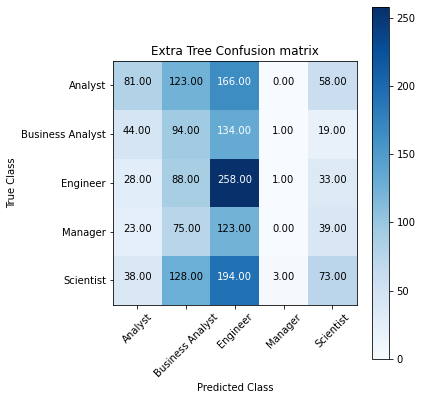

In [113]:
#we will create the confusion matrix as per the function shown earlier
cm_et2 = confusion_matrix(y2_test, yhat_et2)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_et2,question=2, title='Extra Tree Confusion matrix')

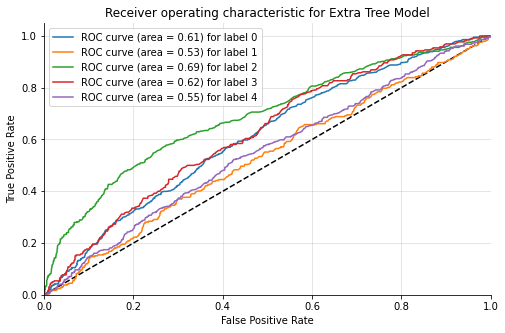

In [114]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_et2,y2_test,5, (8,5), model='Extra Tree Model')

Similar to LR2, this is an overfitted model as shown by comparing the train and test accuracy scores. The model has a very high accuracy with the train data and a very dismal accuracy with test data. It is performing only 3 points better than the baseline; hence, this is not a model we can deploy. Across all metrics with our test data, it's performance is also dismal like that of LR2. Looking at the ROC curve, it is almost close to the middle line for most classes meaning that it is as likely to be incorrect as to be correct.

In [115]:
#get our average AUC
et2_auc= (0.60+0.53+0.69+.63+.54)/5

#summarize the performance metrics for ET2 model
results_et2= pd.Series({'model': 'Extra Tree with CountVectorizer',
                        'train_accuracy': et2_train_score,
                        'test_accuracy': et2_test_score,
                        'ave_precision': et2_report['weighted avg']['precision'],
                        'ave_recall': et2_report['weighted avg']['recall'],
                        'ave_AUC': et2_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[1]= results_et2
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598


##### V.2.iii Stochastic Gradient Descent (SGD) with dtm created using CountVectorizer

In [116]:
# sgd_params = {
#             'loss':['squared_loss','huber'],
#             'penalty':['l1','l2', 'elasticnet'],
#             'alpha':np.logspace(-5,1,25)
#         }
        
        
# sgd = SGDClassifier()

# model = GridSearchCV(sgd, sgd_params, cv=3, verbose=1, n_jobs=-1)
# model.fit(X2s_train, y2_train)
# print("SGD best params:", model.best_params_)
# print("SGD best score:", model.best_score_)
# print("SGD best estimator:", model.best_estimator_)
# sgd2 = model.best_estimator_

#parameters used below are from the result of the above grid search. commented out as it takes a long time to run this gridsearch

In [117]:
#initialize our model and fit and score with our train data. note that the parameters were based on result of a grid search. 
sgd2= SGDClassifier(alpha= 0.1778, loss='huber', penalty='l2')
sgd2_train_score= np.mean(cross_val_score(sgd2, X2s_train, y2_train, cv=3, n_jobs=-1, verbose=1))
sgd2_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.9s finished


0.6524667143035866

In [118]:
#score our model with our test data
sgd2_test_score= sgd2.fit(X2s_train, y2_train).score(X2s_test, y2_test)
sgd2_test_score

0.2631578947368421

In [119]:
#get confidence scores for our test data
y_score_sgd2= sgd2.decision_function(X2s_test)


#get the predicted value for our test data
yhat_sgd2= sgd2.predict(X2s_test)

#create a classification report. the output is a dictionary which we can access
sgd2_report= classification_report(y2_test, yhat_sgd2, output_dict=True)

print(classification_report(y2_test, yhat_sgd2))

                  precision    recall  f1-score   support

         Analyst       0.28      0.35      0.31       428
Business Analyst       0.17      0.26      0.20       292
        Engineer       0.32      0.41      0.36       408
         Manager       0.12      0.01      0.01       260
       Scientist       0.28      0.19      0.23       436

        accuracy                           0.26      1824
       macro avg       0.23      0.24      0.22      1824
    weighted avg       0.25      0.26      0.24      1824



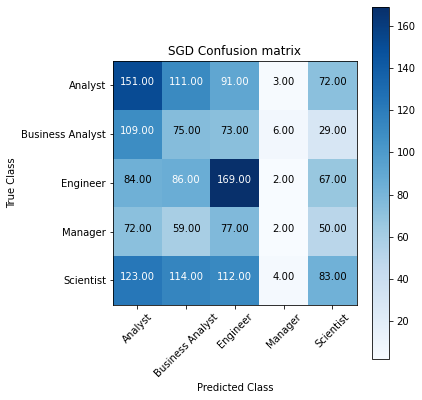

In [120]:
#we will create the confusion matrix as per the function shown earlier
cm_sgd2 = confusion_matrix(y2_test, yhat_sgd2)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_sgd2,question=2, title='SGD Confusion matrix')

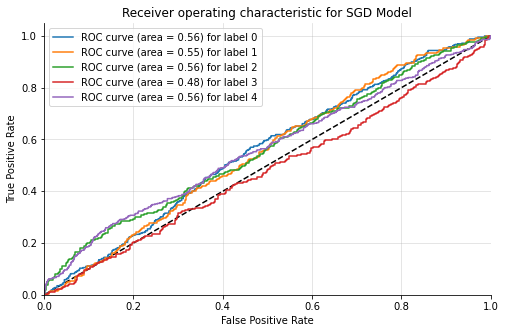

In [121]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_sgd2,y2_test,5, (8,5), model='SGD Model')

As with the above two models, this is an overfitted model as shown by comparing the train and test accuracy scores. The model has a high accuracy with the train data and a very dismal accuracy with test data. It is performing only 2 points better than the baseline; hence, this is not a model we can deploy. Across all metrics with our test data, it's performance is also dismal like that of the above 2 models. Looking at the ROC curve, it is almost close to the middle line for all classes meaning that it is as likely to be incorrect as to be correct.

In [122]:
#get our average AUC
sgd2_auc= (0.56+0.54+0.56+.48+.56)/5

#summarize the performance metrics for SGD2 model
results_sgd2= pd.Series({'model': 'SGD2 with CountVectorizer',
                        'train_accuracy': sgd2_train_score,
                        'test_accuracy': sgd2_test_score,
                        'ave_precision': sgd2_report['weighted avg']['precision'],
                        'ave_recall': sgd2_report['weighted avg']['recall'],
                        'ave_AUC': sgd2_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[2]= results_sgd2
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598
2,SGD2 with CountVectorizer,0.652467,0.263158,0.247820,0.263158,0.540


##### V.2.iv. Logistic Regression with TfidfVectorizer

In [123]:
lr3 = LogisticRegressionCV(penalty= 'l1', max_iter=200, solver= 'liblinear', cv=3, n_jobs=-1, verbose=1)
lr3.fit(X3s_train, y2_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   59.5s finished


LogisticRegressionCV(cv=3, max_iter=200, n_jobs=-1, penalty='l1',
                     solver='liblinear', verbose=1)

In [124]:
#score our model on our train and test data, record the score in a variable
lr3_train_score=lr3.score(X3s_train, y2_train)
lr3_test_score=lr3.score(X3s_test, y2_test)
print('LR2 Train Score:', lr3_train_score)
print('LR2 Test Score:', lr3_test_score)

LR2 Train Score: 0.8586837294332724
LR2 Test Score: 0.6924342105263158


In [125]:
#get confidence scores for our test data
y_score_lr3= lr3.decision_function(X3s_test)

#get the predicted value for our test data
yhat_lr3=lr3.predict(X3s_test)

#create a classification report. the output is a dictionary which we can access
lr3_report= classification_report(y2_test, yhat_lr3, output_dict=True)
print(classification_report(y2_test, yhat_lr3))

                  precision    recall  f1-score   support

         Analyst       0.63      0.69      0.66       428
Business Analyst       0.76      0.73      0.75       292
        Engineer       0.75      0.76      0.76       408
         Manager       0.65      0.62      0.63       260
       Scientist       0.69      0.65      0.67       436

        accuracy                           0.69      1824
       macro avg       0.70      0.69      0.69      1824
    weighted avg       0.69      0.69      0.69      1824



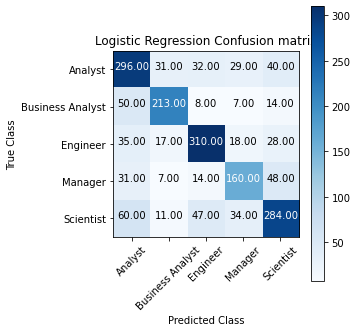

In [126]:
#we will create the confusion matrix as per the function shown earlier
cm_lr3 = confusion_matrix(y2_test, yhat_lr3)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_lr3,size=(5,5),question=2, title='Logistic Regression Confusion matrix')


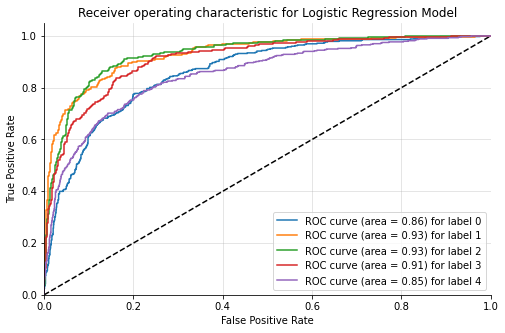

In [127]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_lr3,y2_test,5, (8,5), model='Logistic Regression Model')

This model is a significant improvement compared to the above 3 models. Note that this LR model differs from LR2 by the vectorizer used to create the dtm. This model performs 45 points higher than the baseline for our test data. However, notice that the train accuracy is still significantly higher than test data which shows a slight overfitting which can be expected with a high dimensionality dataset. ROC AUC shows optimal peformance for majority of the classes at a threshold of around 0.8-0.9.

In [128]:
#get our average AUC
lr3_auc= (0.86+0.93+0.93+.91+.85)/5

#summarize the performance metrics for lr3 model
results_lr3= pd.Series({'model': 'Logistic Regression with TfidfVectorizer',
                        'train_accuracy': lr3_train_score,
                        'test_accuracy': lr3_test_score,
                        'ave_precision': lr3_report['weighted avg']['precision'],
                        'ave_recall': lr3_report['weighted avg']['recall'],
                        'ave_AUC': lr3_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[3]= results_lr3
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598
2,SGD2 with CountVectorizer,0.652467,0.263158,0.247820,0.263158,0.540
3,Logistic Regression with TfidfVectorizer,0.858684,0.692434,0.694025,0.692434,0.896


##### V.2.v. Extra Tree Classifier with dtm created using TfidfVectorizer

In [129]:
#initialize our modela and train and score with our train data
et3= ExtraTreesClassifier(n_estimators=1000)
et3_train_score= np.mean(cross_val_score(et3, X3s_train, y2_train, cv=3, n_jobs=-1, verbose=1))
et3_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.0s finished


0.6775137898457976

In [130]:
#score with our test data
et3_test_score= et3.fit(X3s_train, y2_train).score(X3s_test, y2_test)
et3_test_score

0.7176535087719298

In [131]:
#get confidence scores for our test data
y_score_et3= et3.predict_proba(X3s_test)


#get the predicted value for our test data
yhat_et3= et3.predict(X3s_test)

#create a classification report. the output is a dictionary which we can access
et3_report= classification_report(y2_test, yhat_et3, output_dict=True)

print(classification_report(y2_test, yhat_et3))

                  precision    recall  f1-score   support

         Analyst       0.67      0.77      0.72       428
Business Analyst       0.82      0.74      0.78       292
        Engineer       0.73      0.85      0.79       408
         Manager       0.80      0.50      0.61       260
       Scientist       0.67      0.65      0.66       436

        accuracy                           0.72      1824
       macro avg       0.74      0.70      0.71      1824
    weighted avg       0.72      0.72      0.71      1824



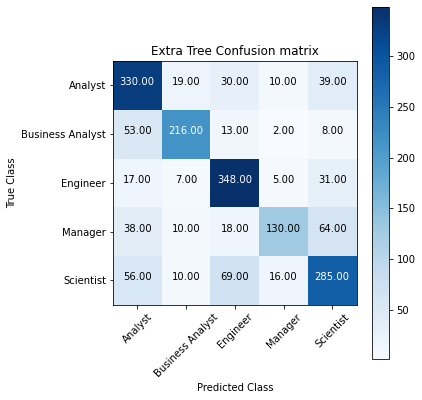

In [132]:
#we will create the confusion matrix as per the function shown earlier
cm_et3 = confusion_matrix(y2_test, yhat_et3)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_et3,question=2, title='Extra Tree Confusion matrix')

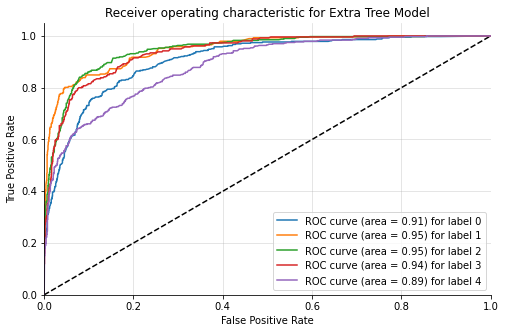

In [133]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_et3,y2_test,5, (8,5), model='Extra Tree Model')

The performance of this model again shows that using TfidfVectorizer does better than CountVectorizer especially when e compare it with ET2 above. This model performs about 50 points higher than the baseline for our test data. This model does not show signs of overfitting showing how Extra Tree can handle the dimensionality of our data better compared to LR. ROC AUC shows optimal peformance for majority of the classes at a threshold of around 0.75-0.9.

In [134]:
#get our average AUC
et3_auc= (0.91+0.95+0.95+.94+.89)/5

#summarize the performance metrics for et3 model
results_et3= pd.Series({'model': 'Extra Tree with TfidfVectorizer',
                        'train_accuracy': et3_train_score,
                        'test_accuracy': et3_test_score,
                        'ave_precision': et3_report['weighted avg']['precision'],
                        'ave_recall': et3_report['weighted avg']['recall'],
                        'ave_AUC': et3_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[4]= results_et3
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598
2,SGD2 with CountVectorizer,0.652467,0.263158,0.247820,0.263158,0.540
3,Logistic Regression with TfidfVectorizer,0.858684,0.692434,0.694025,0.692434,0.896
4,Extra Tree with TfidfVectorizer,0.677514,0.717654,0.724808,0.717654,0.928


##### V.2.vi. Stochastic Gradient Descent (SGD) Classifier with dtm created using TfidfVectorizer

In [135]:
# sgd_params3 = {
#             'loss':['squared_loss','huber'],
#             'penalty':['l1','l2', 'elasticnet'],
#             'alpha':np.logspace(-5,1,25)
#         }
        
        
# sgd_jt = SGDClassifier()

# model = GridSearchCV(sgd_jt, sgd_params3, cv=3, verbose=1, n_jobs=-1)
# model.fit(X3s_train, y2_train)
# print("SGD best params:", model.best_params_)
# print("SGD best score:", model.best_score_)
# print("SGD best estimator:", model.best_estimator_)
# sgd3 = model.best_estimator_

#hyperparameters used below are result of the above gridsearch.
#commented out as this takes a long time to run

In [136]:
#initialize model and train and score with our train data. Note parameters are detrmined by doing the above grid search
sgd3= SGDClassifier(alpha= 0.3162, loss='huber', penalty='l2')
sgd3_train_score= np.mean(cross_val_score(sgd3, X3s_train, y2_train, cv=3, n_jobs=-1, verbose=1))
sgd3_train_score

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.5s finished


0.6265085024684586

In [137]:
#score model with our test data
sgd3_test_score= sgd3.fit(X3s_train, y2_train).score(X3s_test, y2_test)
sgd3_test_score

0.6419956140350878

In [138]:
#get confidence scores for our test data
y_score_sgd3= sgd3.decision_function(X3s_test)


#get the predicted value for our test data
yhat_sgd3= sgd3.predict(X3s_test)

#create a classification report. the output is a dictionary which we can access
sgd3_report= classification_report(y2_test, yhat_sgd3, output_dict=True)

print(classification_report(y2_test, yhat_sgd3))

                  precision    recall  f1-score   support

         Analyst       0.65      0.61      0.63       428
Business Analyst       0.77      0.74      0.75       292
        Engineer       0.63      0.87      0.73       408
         Manager       0.70      0.32      0.44       260
       Scientist       0.55      0.58      0.57       436

        accuracy                           0.64      1824
       macro avg       0.66      0.63      0.62      1824
    weighted avg       0.65      0.64      0.63      1824



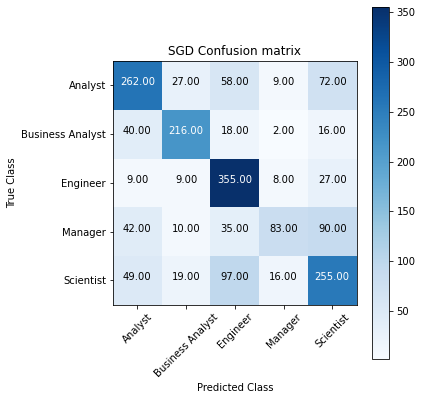

In [139]:
#we will create the confusion matrix as per the function shown earlier
cm_sgd3 = confusion_matrix(y2_test, yhat_sgd3)
np.set_printoptions(precision=2)
plot_confusion_matrix(cm_sgd3,question=2, title='SGD Confusion matrix')

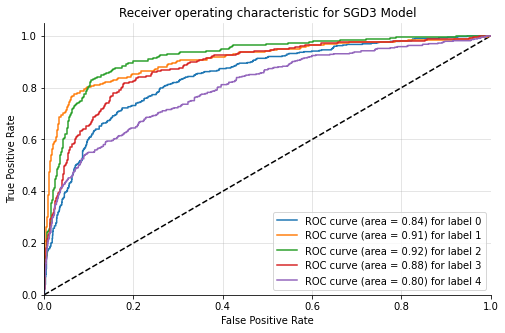

In [140]:
#plot the ROC curve per class using our multiclass_roc function shown above
plot_multiclass_roc(y_score_sgd3,y2_test,5, (8,5), model='SGD3 Model')

This model performed better compared to SDG2 and the Baseline. However, it is not performing better than Extra Tree or Logistic Regression (using TfidfVectorizer) in any of the metrics. As a model, it is acceptable in that it is a 40 point improvement than the baseline and not overfitted. Performs optimal for all classes woth threshold of 0.65-0.9 based on the ROC curve.

In [141]:
#get our average AUC
sgd3_auc= (0.85+0.91+0.92+.88+.80)/5

#summarize the performance metrics for SGD3 model
results_sgd3= pd.Series({'model': 'SGD3 with TfidfVectorizer',
                        'train_accuracy': sgd3_train_score,
                        'test_accuracy': sgd3_test_score,
                        'ave_precision': sgd3_report['weighted avg']['precision'],
                        'ave_recall': sgd3_report['weighted avg']['recall'],
                        'ave_AUC': sgd3_auc })

#add this is our summary df for easier comparison later
results_jobTitle.loc[5]= results_sgd3
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598
2,SGD2 with CountVectorizer,0.652467,0.263158,0.247820,0.263158,0.540
3,Logistic Regression with TfidfVectorizer,0.858684,0.692434,0.694025,0.692434,0.896
4,Extra Tree with TfidfVectorizer,0.677514,0.717654,0.724808,0.717654,0.928
5,SGD3 with TfidfVectorizer,0.626509,0.641996,0.649804,0.641996,0.872


#### V-3. Results and Findings
---
Based on our results, we can see that TfidfVectorizer outperforms CountVectorizer for all 3 models that we used across all metrics.  With a baseline of 0.24, our models that used dtms created through CountVectorizer is not performing significantly better than baseline. Hence, we will now just look at and compare the results of our models that used TfidfVectorizer to create the dtm. 

Looking at our performance summary below, we can see that while Logistic Regression has good accuracy for our train data (sign of overfitting), it is behind Extra Tree in other metrics. Hence, we can say that Extra Tree is the best model among the three we used. 

In [142]:
results_jobTitle

,model,train_accuracy,test_accuracy,ave_precision,ave_recall,ave_AUC
0,Logistic Regression with CountVectorizer,0.845521,0.247807,0.276384,0.247807,0.570
1,Extra Tree with CountVectorizer,0.689760,0.277412,0.262995,0.277412,0.598
2,SGD2 with CountVectorizer,0.652467,0.263158,0.247820,0.263158,0.540
3,Logistic Regression with TfidfVectorizer,0.858684,0.692434,0.694025,0.692434,0.896
4,Extra Tree with TfidfVectorizer,0.677514,0.717654,0.724808,0.717654,0.928
5,SGD3 with TfidfVectorizer,0.626509,0.641996,0.649804,0.641996,0.872


Looking at the coefficients we got from Extra Tree, we can see that the top determinant features we are getting include ba(BA), AWS, cloud, leadership among others. However, again, these do not specify the important words for each job Title. Hence, we will look at the coefficient results from Logistic Regression Model. Analysing the resulting word clouds shown below, we can see that the words appearing per job Title are closely related and make real-world sense. For example, below are some words that appear for each jobTitle:

1. Analysts- Excel, Reporting, SQL, testing
2. Business Analyst- Requirements, gathering, stakeholder, visio, agile
3. Engineer- Solution, design, architecture, AWS, technology, database
4. Manager- Leadership, budget, product, strategy, oversee
5. Scientist- Specialist, expert, model, research, PhD, master, papers, conceptual

#### Coefficients from Extra Tree

In [143]:
coefs_et3= list(et3.feature_importances_)
coefs_abs_et3=np.abs(coefs_et3)
output_et3 = pd.DataFrame({'variable':tfidf_train.columns,
                            'coef':coefs_et3,
                            'abs_coef':coefs_abs_et3})
output_et3.sort_values('abs_coef', inplace=True, ascending=False)
output_et3.head(20)

,variable,coef,abs_coef
1922,requirements,0.007471,0.007471
169,architecture,0.007159,0.007159
133,analysis,0.006551,0.006551
507,consultant,0.006141,0.006141
651,design,0.005593,0.005593
1924,research,0.004796,0.004796
2093,solution,0.004491,0.004491
2380,user,0.004323,0.004323
1298,lead,0.003985,0.003985
2114,specialist,0.003810,0.003810


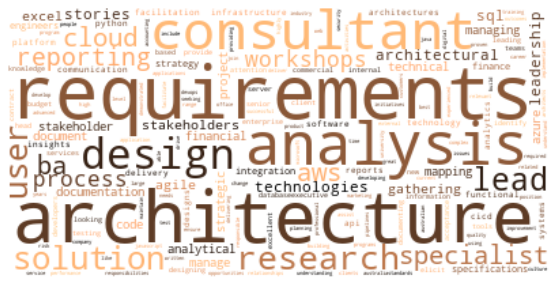

In [144]:
create_wordcloud(output_et3)

#### Coefficients per JobTitle taken through the Logistic Regression model

In [145]:
#function to get coefficients for each jobTitle

def show_coefs_lr3(jobTitle, head=30, wcloud=True):
    i=None
    if jobTitle=='Analyst':
        i=0
    elif jobTitle=='Business Analyst':
        i=1
    elif jobTitle=='Engineer':
        i=2
    elif jobTitle=='Manager':
        i=3
    elif jobTitle== 'Scientist':
        i=4
    else:
        pass
    
    #create our coefficient df
    if i!=None:
        coefs_lr3= list(lr3.coef_[i])
        coefs_abs_lr3=np.abs(coefs_lr3)
        output_lr3= pd.DataFrame({'variable':tfidf_train.columns,
                                    'coef':coefs_lr3,
                                    'abs_coef':coefs_abs_lr3})
        output_lr3.sort_values('coef', inplace=True, ascending=False)

    else:
        print('Job Title not recognised. Please choose from: Analyst, Business Analyst, Engineer, Manager, and Scientist')
    
    #determine if output is either a wordcloud or printout the head of our df
    if wcloud==True:
        create_wordcloud(output_lr3)
    else:
        print(output_lr3.head(head))


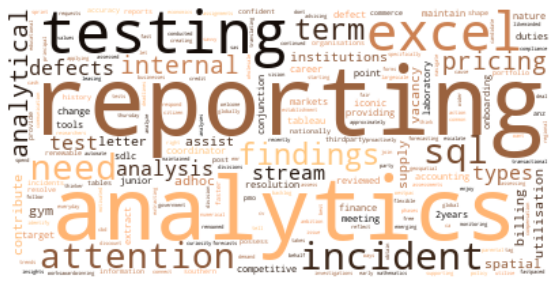

In [146]:
show_coefs_lr3('Analyst')

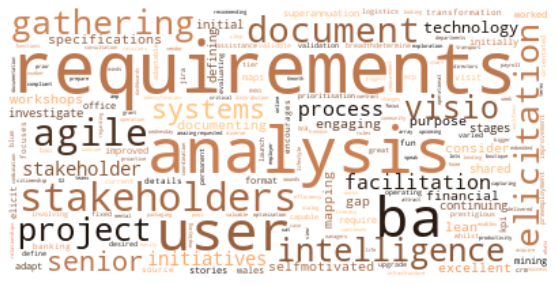

In [147]:
show_coefs_lr3('Business Analyst')

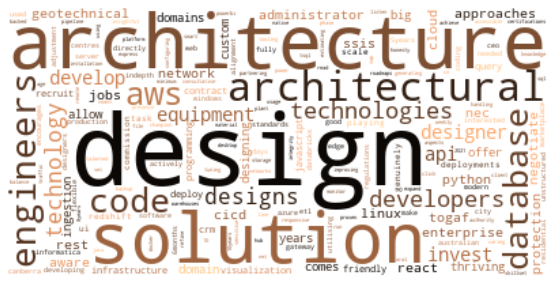

In [148]:
show_coefs_lr3('Engineer')

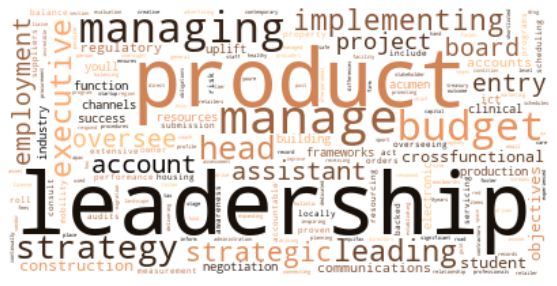

In [149]:
show_coefs_lr3('Manager')

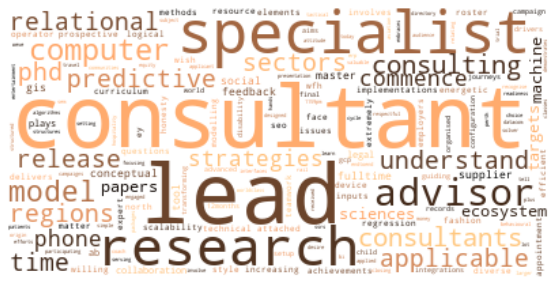

In [150]:
show_coefs_lr3('Scientist')

### VI. Conclusion
---

Using Natural Language Processing and Classification techniques, different models were created that allows us to predict our targets. 

For the Salary range prediction, after creating our document term matrix using CountVectorizer, the two ensemble models (Random Forest and Extra Tree) performed best with Logistic regression following closely. Extra Tree in particular handled our highly dimensional data the best with accuracy score 30 points higher than our baseline. In terms of identifying words that determine how to predict Salary range, the coefficients from our model tells us which words drive our model. However, the extra tree does not give us the words that determine each class. If want to check the words closely related to each class in our target (each salary range), as Logistic Regression is not falling far behind from the ensemble models across all metrics. 

For the JobTitle prediction, models with dtm from CountVectorizer did not perform significantly better than our Baseline. In fact some, performed worse. Meanwhile, models with tfidfVectorizer are able to outperform the baseline with by close to 50 points. Similar to above, Extra Tree performed best among the three models used. Logistic Regression while slightly overfitted still performed almost at par with Extra Tree with our test data. Hence, we can use this model to get the words/variables that determine each class.

### VII. Recommendations for Future Work
---

For future work, below are possible extension to the project:

1. We can retrieve more data with dollar-point salary data to be able to use a regression model for Salary and predict actual Salary instead of a salary range. 
2. We can retrieve similar data from other platforms. 
3. We can also extend this work to jobs in other fields. 
4. We can also use and analyse performance of other models. 

### VIII. Acknowledgment
---

This project would not have been completed without the guidance and support of the following:
- Srikanta Patra
- Brian Farrell
- DSIR14 squad
- Meiling Lee (bestfriend extraordinaire)

### IX. Appendix

#### Scrapy


### The below spider is ran outside jupyter notebook through the terminal

In [153]:

# import scrapy
# from urllib.parse import urljoin
# import time

# class SeekSpider(scrapy.Spider):
#     name= "seek"
#     allowed_domains = ["seek.com.au"]

#     def start_requests(self):
#         # list of star urls
#         urls = ['https://www.seek.com.au/data-jobs?salaryrange=0-40000&salarytype=annual'
#         ,'https://www.seek.com.au/data-jobs?salaryrange=50000-70000&salarytype=annual'
#         , 'https://www.seek.com.au/data-jobs?salaryrange=80000-120000&salarytype=annual'
#         , 'https://www.seek.com.au/data-jobs?salaryrange=150000-200000&salarytype=annual'
#         , 'https://www.seek.com.au/data-jobs?salaryrange=200000-999999&salarytype=annual'
#         ,]
#         #to pass the index of each url as it will be used to determine the salary range
#         for index, url in enumerate(urls):
#             yield scrapy.Request(url, callback=self.parse, cb_kwargs={'index':index})

#     def parse(self, response, index):
#         #determine salary range by the start url we are in
#         if index==0:
#             sal_range= 'low'
#         elif index==1:
#             sal_range='mid_low'
#         elif index==2:
#             sal_range= 'mid'
#         elif index==3:
#             sal_range='mid_high'
#         else:
#             sal_range='high'

#         urls = response.xpath('//a[@data-automation="jobTitle"]/@href').extract()
#         jobID= response.xpath('//article/@data-job-id').extract()

#         for id_index, href in enumerate(urls):
#             j_ID=jobID[id_index]
#             url=response.urljoin(href)
#             yield scrapy.Request(url = url, callback =self.parse_details, cb_kwargs={'url':url, 'j_ID': j_ID, 'sal_range':sal_range} )

#         time.sleep(3)

#         next_page = response.xpath('//a[@data-automation="page-next"]//@href').extract_first()

#         if next_page is not None:
#             print('*************TRY**************************')
#             next_page = response.urljoin(next_page)
#             yield scrapy.Request(next_page, callback = self.parse,cb_kwargs={'index':index} )

# #get job details witin the individual job urls
#     def parse_details(self, response, url, j_ID, sal_range):
#         #get job details based on xpath
#         yield {
#             'jobID':j_ID,
#             'jobLink':url,
#             'jobTitle': response.xpath('//h1[@data-automation="job-detail-title"]//text()').get(),
#             'jobCompany': response.xpath('//span[@data-automation="advertiser-name"]//text()').get(),
#             'jobLocation': response.xpath('//span[@class="FYwKg _2Bz3E C6ZIU_4 _6ufcS_4 _2DNlq_4 _29m7__4 _2WTa0_4"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').get(),
#             'jobArea': response.xpath('//div[@class="FYwKg _3VxpE_4"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').getall(),
#             'Industry': response.xpath('//div[@class="FYwKg _3VxpE_4"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').getall()[-2],
#             'Industry_details': response.xpath('//div[@class="FYwKg _3VxpE_4"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').getall()[-1],
#             'jobAdDetails': response.xpath('//div[@data-automation="jobAdDetails"]//text()').getall(),
#             'Worktype': response.xpath('//div[@data-automation="job-detail-work-type"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').getall(),
#             'Worktype2': response.xpath('//div[@data-automation="job-detail-work-type"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').getall()[-1],
#             # 'SeekExpectedSalary':response.xpath('//span[@class="lmis-cg-salary-mode"]//text()').get(),
#             'Salary': response.xpath('//div[@data-automation="job-detail-work-type"]//div[@class="FYwKg PrHFr _1EtT-_4"]//text()').get(),
#             'Salary_range': sal_range,
#             }

### EXTRAS- Unsupervised learning
---
As an extra, I also took a look at unsupervised learning- topic modelling to find any hidden classification to our jobAdDetails and check if these can be used to determine our target classes. Latent Dirilecht Allocation was used for topic modelling. Based on the results below, we can see that LDA is nmot giving us any significant grouping that could relate to our targets for both the Salary Prediction and the JobTitle prediction. 

#### Salary prediction

In [151]:
#create dtm using our CountVectorizer
dtm1=cvec.transform(dtm_train)

#initialize and fit our LDA model with 3 components representiung the number of grouping we want
lda_tf= LatentDirichletAllocation(n_components=3, random_state=0)
lda_tf.fit(dtm1)

#visualize
lda_vis_tf= pyLDAvis.sklearn.prepare(lda_tf, dtm1, my_vect)
pyLDAvis.display(lda_vis_tf)

From the above visualization, we can see that while 3 distinct clusters are formed, looking at the words that appear significant per class, we can see that these words does not relate to our targets in any way. 

#### JobTitle Prediction

In [152]:
#get tfidf dtm
dtm2=my_vect.transform(oX2_train)

#initialize and fit the model. n_components represent the number of clusters we want to form. 
lda_tf2= LatentDirichletAllocation(n_components=5, random_state=0)
lda_tf2.fit(dtm2)

#visualize
lda_vis_tf= pyLDAvis.sklearn.prepare(lda_tf2, dtm2, my_vect)
pyLDAvis.display(lda_vis_tf)

From the above visualization, we can see that there are 3 distinct clusters and 2 clusters that overlap (this could be more distinguishable if we add dimensions but that is difficult to visualize) formed. Looking at the words that appear significant per class, we can see that these wordscan slightly give us some signal. We can relate some clusters formed with our targets in the following way: 2 has similarities we got for Engineer role, 3 is closely similar to Business Analyst results. However, clusters 4 and 5 look to have more to do with actual industries 5 beling close to government and 4 close to marketing.